In [10]:
import os
os.chdir("/data/t-achetan/adv_geom/src/")

import random
import torch 

import numpy as np
import scipy as sp
import numpy.linalg as npla
import scipy.linalg as spla

import matplotlib.pyplot as plt

from datagen.real.mnist import MNISTManifolds
from datagen.real.manifolds import _get_tn_for_on_mfld_idx
from sklearn.decomposition import PCA

In [2]:
cfg_dict = MNISTManifolds.get_demo_cfg_dict()
cfg_dict["train"]["num_neg"] = 0
cfg_dict["train"]["k"] = 10
cfg_dict["train"]["nn"] = 10
cfg_dict["train"]["on_mfld_path"] = "/mnt/t-achetan/datasets/"
cfg_dict["val"]["num_neg"] = 0
cfg_dict["val"]["k"] = 10
cfg_dict["val"]["nn"] = 10
cfg_dict["val"]["on_mfld_path"] = "/mnt/t-achetan/datasets/"
cfg_dict["test"]["num_neg"] = 0
cfg_dict["test"]["on_mfld_path"] = "/mnt/t-achetan/datasets/"
cfg_dict["test"]["k"] = 10
cfg_dict["test"]["nn"] = 10

cfg_dict

{'strategy': 'only',
 'has_val': False,
 'train': {'on_mfld_path': '/mnt/t-achetan/datasets/',
  'k': 10,
  'n': 784,
  'use_labels': [1, 8],
  'off_mfld_label': 9,
  'split': 'train',
  'seed': 23,
  'num_neg': 0,
  'nn': 10,
  'buf_nn': 2,
  'max_t_delta': 0.001,
  'max_norm': 0.1,
  'M': 1.0,
  'transform': None},
 'val': {'on_mfld_path': '/mnt/t-achetan/datasets/',
  'k': 10,
  'n': 784,
  'use_labels': [1, 8],
  'off_mfld_label': 9,
  'split': 'test',
  'seed': 23,
  'num_neg': 0,
  'nn': 10,
  'buf_nn': 2,
  'max_t_delta': 0.001,
  'max_norm': 0.1,
  'M': 1.0,
  'transform': None},
 'test': {'on_mfld_path': '/mnt/t-achetan/datasets/',
  'k': 10,
  'n': 784,
  'use_labels': [1, 8],
  'off_mfld_label': 9,
  'split': 'test',
  'seed': 23,
  'num_neg': 0,
  'nn': 10,
  'buf_nn': 2,
  'max_t_delta': 0.001,
  'max_norm': 0.1,
  'M': 1.0,
  'transform': None}}

In [3]:
trainset = MNISTManifolds(**cfg_dict["train"])
trainset.compute_points()

12-06-2022 19:17:47 -- [I] root | [mnist.py:93 -     load_raw_om_data()] >> [MNISTManifolds]: loading MNIST dataset
12-06-2022 19:17:48 -- [I] root | [mnist.py:96 -     load_raw_om_data()] >> [MNISTManifolds]: MNIST data loaded
flattening data: 8it [00:01,  4.22it/s]
12-06-2022 19:17:50 -- [I] root | [manifolds.py:461 -       compute_points()] >> [MNISTManifolds]: initialised on-mfld points
12-06-2022 19:17:50 -- [I] root | [manifolds.py:465 -       compute_points()] >> [MNISTManifolds]: created poca idx
12-06-2022 19:17:50 -- [I] root | [manifolds.py:321 - make_inferred_off_mfld()] >> [MNISTManifolds]: knn not computed. computing now ...
12-06-2022 19:17:50 -- [I] root | [manifolds.py:288 -             find_knn()] >> [MNISTManifolds]: fitting knn...
12-06-2022 19:17:53 -- [I] root | [manifolds.py:290 -             find_knn()] >> [MNISTManifolds]: knn fit done
12-06-2022 19:17:53 -- [I] root | [manifolds.py:292 -             find_knn()] >> [MNISTManifolds]: predicting nbhrs...
12-06-20

In [4]:
def seed_all(manual_seed):
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)
    torch.cuda.manual_seed(manual_seed)
    np.random.seed(manual_seed)

In [26]:
def make_offmfld_eg(trainset, idx, off_mfld_size, on_mfld_size, seed=43):
    
    seed_all(seed)
    
    nn_indices = trainset.nn_indices[trainset.nn_indices != np.arange(trainset.nn_indices.shape[0]).reshape(-1, 1)].reshape(trainset.nn_indices.shape[0], trainset.nn_indices.shape[1] - 1)
    nn_distances = trainset.nn_distances[trainset.nn_indices != np.arange(trainset.nn_indices.shape[0]).reshape(-1, 1)].reshape(trainset.nn_indices.shape[0], trainset.nn_indices.shape[1] - 1)

    idx = 0
    pt = trainset.all_points[idx]
    nbhrs = trainset.all_points[nn_indices[idx]]
    nbhr_local_coords = nbhrs - pt
    pca = PCA(n_components=trainset.k - 1)
    pca.fit(nbhr_local_coords)

    tang_dirs = pca.components_
    norm_dirs = spla.null_space(tang_dirs).T

    on_mfld_pb_coeffs = np.random.normal(size=trainset.k - 1)
    on_mfld_pb = np.sum(on_mfld_pb_coeffs.reshape(-1, 1) * tang_dirs, axis=0)
    on_mfld_pb = on_mfld_pb * (on_mfld_size / np.linalg.norm(on_mfld_pb, ord=2))

    on_mfld_aug = pt + on_mfld_pb

    off_mfld_coeffs = np.random.normal(size=trainset.n - trainset.k + 1)
    off_mfld_pb = np.sum(off_mfld_coeffs.reshape(-1, 1) * norm_dirs, axis=0)

    off_mfld_pb = off_mfld_pb * (off_mfld_size / np.linalg.norm(off_mfld_pb, ord=2))

    off_mfld_pt = on_mfld_aug + off_mfld_pb
    
    return pt, on_mfld_aug, off_mfld_pt

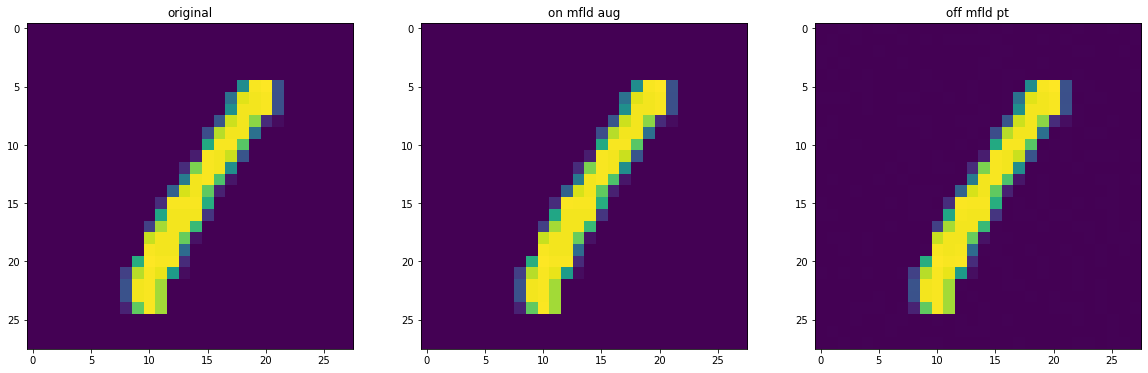

In [27]:
idx = 0
off_mfld_size = 0.1
on_mfld_size = 1e-3

pt, on_mfld_aug, off_mfld_eg = make_offmfld_eg(trainset, idx, off_mfld_size, on_mfld_size)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].imshow(pt.reshape(28, 28))
axs[0].set_title("original")
axs[1].imshow(on_mfld_aug.reshape(28, 28))
axs[1].set_title("on mfld aug")
axs[2].imshow(off_mfld_eg.reshape(28, 28))
axs[2].set_title("off mfld pt")

plt.show()